In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

In [3]:
#KL divergence
from scipy.stats import entropy
#entropy(cumsum_lh_y[0], cumsum_lh_y[1])

#コサイン類似度
from sklearn.metrics.pairwise import cosine_similarity
#cosine_similarity(cumsum_lh_y[0].reshape(1, -1), cumsum_lh_y[1].reshape(1, -1))

#np.correlate(cumsum_lh_y[0], cumsum_lh_y[4], "full")

#対応のある/ないt検定
#ANOVA/分散分析
#Tukey HSD/多重比較
#Dunnet /基準群vsの多重比較
#サンプルサイズ設計
#Wilcoxon/ノンパラの中央値
#マンホイットニー/ノンパラの中央値
#Kruskal wallis/ノンパラのANOVA
#コルモゴロフ-スミルノフ検定/正規性or基準分布との同一性
"""
それぞれの母集団の経験分布を計算して、その差が最も大きくなるところを検定統計量としている
ノンパラの検定で、標本が同一分布から生成されたかどうかを検定
対象の分布が正規分布であることを仮定しない
"""
from scipy import stats
#stats.ks_2samp(x1, x2)


#正規化相互相関
def normalized_cross_correlation(a, b):
    """
    時系列信号a, bに対して、正規化相互相関 [-1, 1]を返す
    """
    #https://stackoverflow.com/questions/53436231/normalized-cross-correlation-in-python
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    c = np.correlate(a, b, 'full')
    return c


def unbiased_std(x):
    """
    不偏標準偏差
    """
    return np.std(x, ddof=1)


#ピアソンの相関係数
#スピアマンの相関係数/ノンパラの相関


'\n対応のある/ないt検定\nANOVA/分散分析\nTukey HSD/多重比較\nDunnet /基準群vsの多重比較\nサンプルサイズ設計\nWilcoxon/ノンパラの中央値\nマンホイットニー/ノンパラの中央値\nKruskal wallis/ノンパラのANOVA\nコルモゴロフ-スミルノフ検定/正規性or基準分布との同一性\n正規化相互相関\nピアソンの相関係数\nスピアマンの相関係数/ノンパラの相関\n'

In [ ]:
"""
q-qプロット
"""

#X, Y:分布が同一かどうかを評価したいサンプル
"""
#test code A
xd = np.linspace(0, 1, 100)
xx0 = np.linspace(0, 1, len(X))
yy0 = np.array(sorted(X))
f0 = interp1d(xx0, yy0, kind="cubic")(xd)

xx1 = np.linspace(0, 1, len(Y))
yy1 = np.array(sorted(Y))
f1 = interp1d(xx1, yy1, kind="cubic")(xd)

plt.figure(figsize=(6,6))
plt.plot(f0, f1, color="k", label="q-q plot")
plt.plot([f0.min(), f0.max()], [f1.min(), f1.max()], color="b", label="baseline")
plt.xlim([f0.min(), f0.max()])
plt.ylim([f1.min(), f1.max()])

plt.title("Splined q-q plot")
plt.legend()
"""

"""
testcode B

from statsmodels.graphics.gofplots import ProbPlot, qqplot_2samples
pp_x = ProbPlot(X)
pp_y = ProbPlot(np.random.choice(Y), len(X))
qqplot_2samples(pp_x, pp_y)
"""

In [ ]:
##
# Brunner-Munzel検定
# http://ajhjhaf.hatenablog.com/entry/2018/12/22/160652
##

"""
不当分散のときに使えるノンパラメトリック検定です。
ランクから、得られたデータの中央値に有意差があるか検出します。 
ノンパラメトリックの検定では、Wilcoxon-Mann-WhitneyのU検定が非常に有名ですが、
この検定は不当分散の場合には第一種の過誤を得る確率が5%にならない場合があり、
適切な手法として使えません。 詳しい調査には、以下のような先行記事があります。
#http://hoxo-m.hatenablog.com/entry/20150217/p1
"""

#from scipy ver 1.2.0
from collections import namedtuple
from scipy.stats import rankdata
from scipy.stats import distributions

def _contains_nan(a, nan_policy='propagate'):
    policies = ['propagate', 'raise', 'omit']
    if nan_policy not in policies:
        raise ValueError("nan_policy must be one of {%s}" %
                         ', '.join("'%s'" % s for s in policies))
    try:
        # Calling np.sum to avoid creating a huge array into memory
        # e.g. np.isnan(a).any()
        with np.errstate(invalid='ignore'):
            contains_nan = np.isnan(np.sum(a))
    except TypeError:
        # This can happen when attempting to sum things which are not
        # numbers (e.g. as in the function `mode`). Try an alternative method:
        try:
            contains_nan = np.nan in set(a.ravel())
        except TypeError:
            # Don't know what to do. Fall back to omitting nan values and
            # issue a warning.
            contains_nan = False
            nan_policy = 'omit'
            warnings.warn("The input array could not be properly checked for nan "
                          "values. nan values will be ignored.", RuntimeWarning)

    if contains_nan and nan_policy == 'raise':
        raise ValueError("The input contains nan values")

return (contains_nan, nan_policy)

BrunnerMunzelResult = namedtuple('BrunnerMunzelResult',
                                 ('statistic', 'pvalue'))


def brunnermunzel(x, y, alternative="two-sided", distribution="t",
                  nan_policy='propagate'):
    """
    Computes the Brunner-Munzel test on samples x and y
    The Brunner-Munzel test is a nonparametric test of the null hypothesis that
    when values are taken one by one from each group, the probabilities of
    getting large values in both groups are equal.
    Unlike the Wilcoxon-Mann-Whitney's U test, this does not require the
    assumption of equivariance of two groups. Note that this does not assume
    the distributions are same. This test works on two independent samples,
    which may have different sizes.
    Parameters
    ----------
    x, y : array_like
        Array of samples, should be one-dimensional.
    alternative :  'less', 'two-sided', or 'greater', optional
        Whether to get the p-value for the one-sided hypothesis ('less'
        or 'greater') or for the two-sided hypothesis ('two-sided').
        Defaults value is 'two-sided' .
    distribution: 't' or 'normal', optional
        Whether to get the p-value by t-distribution or by standard normal
        distribution.
        Defaults value is 't' .
    nan_policy : {'propagate', 'raise', 'omit'}, optional
        Defines how to handle when input contains nan. 'propagate' returns nan,
        'raise' throws an error, 'omit' performs the calculations ignoring nan
        values. Default is 'propagate'.
    Returns
    -------
    statistic : float
        The Brunner-Munzer W statistic.
    pvalue : float
        p-value assuming an t distribution. One-sided or
        two-sided, depending on the choice of `alternative` and `distribution`.
    See Also
    --------
    mannwhitneyu : Mann-Whitney rank test on two samples.
    Notes
    -------
    Brunner and Munzel recommended to estimate the p-value by t-distribution
    when the size of data is 50 or less. If the size is lower than 10, it would
    be better to use permuted Brunner Munzel test (see [2]_).
    References
    ----------
    .. [1] Brunner, E. and Munzel, U. "The nonparametric Benhrens-Fisher
           problem: Asymptotic theory and a small-sample approximation".
           Biometrical Journal. Vol. 42(2000): 17-25.
    .. [2] Neubert, K. and Brunner, E. "A studentized permutation test for the
           non-parametric Behrens-Fisher problem". Computational Statistics and
           Data Analysis. Vol. 51(2007): 5192-5204.
    Examples
    --------
    >>> from scipy import stats
    >>> x1 = [1,2,1,1,1,1,1,1,1,1,2,4,1,1]
    >>> x2 = [3,3,4,3,1,2,3,1,1,5,4]
    >>> w, p_value = stats.brunnermunzel(x1, x2)
    >>> w
    3.1374674823029505
    >>> p_value
    0.0057862086661515377
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # check both x and y
    cnx, npx = _contains_nan(x, nan_policy)
    cny, npy = _contains_nan(y, nan_policy)
    contains_nan = cnx or cny
    if npx == "omit" or npy == "omit":
        nan_policy = "omit"

    if contains_nan and nan_policy == "propagate":
        return BrunnerMunzelResult(np.nan, np.nan)
    elif contains_nan and nan_policy == "omit":
        x = ma.masked_invalid(x)
        y = ma.masked_invalid(y)
        return mstats_basic.brunnermunzel(x, y, alternative, distribution)

    nx = len(x)
    ny = len(y)
    if nx == 0 or ny == 0:
        return BrunnerMunzelResult(np.nan, np.nan)
    rankc = rankdata(np.concatenate((x, y)))
    rankcx = rankc[0:nx]
    rankcy = rankc[nx:nx+ny]
    rankcx_mean = np.mean(rankcx)
    rankcy_mean = np.mean(rankcy)
    rankx = rankdata(x)
    ranky = rankdata(y)
    rankx_mean = np.mean(rankx)
    ranky_mean = np.mean(ranky)

    Sx = np.sum(np.power(rankcx - rankx - rankcx_mean + rankx_mean, 2.0))
    Sx /= nx - 1
    Sy = np.sum(np.power(rankcy - ranky - rankcy_mean + ranky_mean, 2.0))
    Sy /= ny - 1

    wbfn = nx * ny * (rankcy_mean - rankcx_mean)
    wbfn /= (nx + ny) * np.sqrt(nx * Sx + ny * Sy)

    if distribution == "t":
        df_numer = np.power(nx * Sx + ny * Sy, 2.0)
        df_denom = np.power(nx * Sx, 2.0) / (nx - 1)
        df_denom += np.power(ny * Sy, 2.0) / (ny - 1)
        df = df_numer / df_denom
        p = distributions.t.cdf(wbfn, df)
    elif distribution == "normal":
        p = distributions.norm.cdf(wbfn)
    else:
        raise ValueError(
            "distribution should be 't' or 'normal'")

    if alternative == "greater":
        p = p
    elif alternative == "less":
        p = 1 - p
    elif alternative == "two-sided":
        p = 2 * np.min([p, 1-p])
    else:
        raise ValueError(
            "alternative should be 'less', 'greater' or 'two-sided'")

return BrunnerMunzelResult(wbfn, p)

In [4]:
def normalized_cross_correlation(a, b):
    """
    時系列信号a, bに対して、正規化相互相関 [-1, 1]を返す
    """
    #https://stackoverflow.com/questions/53436231/normalized-cross-correlation-in-python
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    c = np.correlate(a, b, 'full')
    return c


def unbiased_std(x):
    """
    不偏標準偏差
    """
    return np.std(x, ddof=1)

# 検出力に基づくサンプルサイズ設計

In [6]:
from scipy.stats import norm
norm.isf(q=0.025, loc=0, scale=1)

1.9599639845400545

In [8]:
"""
一つの母平均の検定 母分散が既知の場合
"""

from scipy.stats import norm
norm.isf(q=0.16, loc=0, scale=1)

#H0:mu=mu0, H1:mu!=mu0の場合のサンプルサイズ
def size_mean_mu_ne_mu0(delta, mu=None, mu0=None, sigma0=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 3.15
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma0):
        delta = (mu-mu0)/sigma0
        
    else:
        raise ValueError("Must set delta as a threshold or set mu, mu0, sigma0")
    
    if alpha>0.5:
        z_alpha_over_two =norm.isf(q=(1-alpha)/2, loc=0, scale=1)
    else:
        z_alpha_over_two =norm.isf(q=alpha/2, loc=0, scale=1)
    
    z_one_minus_beta = norm.isf(q=one_minus_beta, loc=0, scale=1)
    n = ((z_alpha_over_two-z_one_minus_beta)/delta)**2
    
    return n

print(size_mean_mu_ne_mu0(1.0, alpha=0.05, one_minus_beta=0.9))

10.507423061440623

In [20]:
def statistical_power_mean_mu_ne_mu0(delta, n, mu=None, mu0=None, sigma0=None, alpha=0.05):
    #Eq. 3.6
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma0):
        delta = (mu-mu0)/sigma0
        
    else:
        raise ValueError("Must set delta as a threshold or set mu, mu0, sigma0")
    
    if alpha>0.5:
        z_alpha_over_two =norm.isf(q=(1-alpha)/2, loc=0, scale=1)
    else:
        z_alpha_over_two =norm.isf(q=alpha/2, loc=0, scale=1)
    
    one_minus_beta = norm.cdf(-z_alpha_over_two-np.sqrt(n)*delta, loc=0, scale=1
                               ) + (1-norm.cdf(z_alpha_over_two-np.sqrt(n)*delta, loc=0, scale=1))
    #same as the situation using survival function sf (sf=1-cdf)
    #z_one_minus_beta = norm.cdf(-z_alpha_over_two-np.sqrt(n)*delta, loc=0, scale=1
    #                           ) + norm.sf(z_alpha_over_two-np.sqrt(n)*delta, loc=0, scale=1))
    
    return one_minus_beta

print(statistical_power_mean_mu_ne_mu0(delta=1.0, n=10))
print(statistical_power_mean_mu_ne_mu0(delta=1.0, n=11))

0.885379140762
0.912555560042


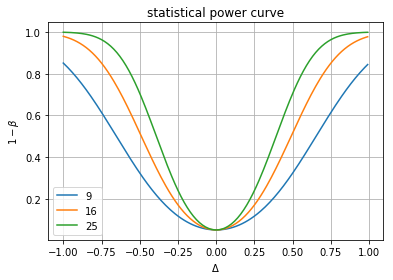

In [34]:
n_list = [9, 16, 25]
delta_list = np.arange(-1, 1, 0.01).tolist()

#fig = plt.figure()
for index, n in enumerate(n_list):
    #ax = fig.add_subplot(len(n_list), 1, index+1)
    #ax.plot(delta_list, [statistical_power_mean_mu_ne_mu0(delta=delta, n=n) for delta in delta_list], label=n)
    plt.plot(delta_list, [statistical_power_mean_mu_ne_mu0(delta=delta, n=n) for delta in delta_list], label=n)
    

plt.title("statistical power curve")
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$1-\beta$")
plt.grid()
plt.legend()

In [14]:
#H0:mu=mu0, H1:mu!=mu0の場合のサンプルサイズ
def size_mean_mu_larger_mu0(delta, mu=None, mu0=None, sigma0=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 3.17
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma0):
        delta = (mu-mu0)/sigma0
        
    else:
        raise ValueError("Must set delta as a threshold or set mu, mu0, sigma0")
    
    if alpha>0.5:
        z_alpha_over_two =norm.isf(q=(1-alpha), loc=0, scale=1)
    else:
        z_alpha_over_two =norm.isf(q=alpha, loc=0, scale=1)
    
    z_one_minus_beta = norm.isf(q=one_minus_beta, loc=0, scale=1)
    n = ((z_alpha_over_two-z_one_minus_beta)/delta)**2
    
    return n

print(size_mean_mu_larger_mu0(0.5, alpha=0.05, one_minus_beta=0.95))

43.2886952655


In [23]:
def statistical_power_mean_mu_larger_mu0(delta, n, mu=None, mu0=None, sigma0=None, alpha=0.05):
    #Eq. 3.9
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma0):
        delta = (mu-mu0)/sigma0
        
    else:
        raise ValueError("Must set delta as a threshold or set mu, mu0, sigma0")
    
    if alpha>0.5:
        z_alpha_over_two =norm.isf(q=(1-alpha), loc=0, scale=1)
    else:
        z_alpha_over_two =norm.isf(q=alpha, loc=0, scale=1)
    
    one_minus_beta = (1-norm.cdf(z_alpha_over_two-np.sqrt(n)*delta, loc=0, scale=1))
    #same as the situation using survival function sf (sf=1-cdf)
    #z_one_minus_beta = norm.sf(z_alpha_over_two-np.sqrt(n)*delta, loc=0, scale=1))
    
    return one_minus_beta

print(statistical_power_mean_mu_ne_mu0(delta=0.5, n=43))
print(statistical_power_mean_mu_ne_mu0(delta=0.5, n=44))

print(size_mean_mu_larger_mu0(-0.5, alpha=0.05, one_minus_beta=0.80))
print(statistical_power_mean_mu_larger_mu0(delta=0.5, n=24))
print(statistical_power_mean_mu_larger_mu0(delta=0.5, n=25))

0.906374610853
0.912555560042
24.7302289281
0.789485152687
0.803764940015


In [24]:
#H0:mu=mu0, H1:mu!=mu0の場合のサンプルサイズ
def size_mean_mu_smaller_mu0(delta, mu=None, mu0=None, sigma0=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 3.17
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma0):
        delta = (mu-mu0)/sigma0
        
    return size_mean_mu_larger_mu0(delta=-delta, mu=None, mu0=None, sigma0=None, alpha=alpha, one_minus_beta=one_minus_beta)


def statistical_power_mean_mu_smaller_mu0(delta, n, mu=None, mu0=None, sigma0=None, alpha=0.05):
    #Eq. 3.9
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma0):
        delta = (mu-mu0)/sigma0
        
    return statistical_power_mean_mu_larger_mu0(delta=-delta, n=n, mu=None, mu0=None, sigma0=None, alpha=alpha)

print(size_mean_mu_smaller_mu0(-0.5, alpha=0.05, one_minus_beta=0.80))
print(statistical_power_mean_mu_smaller_mu0(delta=-0.5, n=24))
print(statistical_power_mean_mu_smaller_mu0(delta=-0.5, n=25))

24.7302289281
0.789485152687
0.803764940015


In [70]:
"""
一つの母分散の検定
"""
from scipy.stats import chi2

#H1:sigma^2!=sigma0^2
def size_var_sigma_ne_sigma0(delta, sigma=None, sigma0=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 4.18, 4.19
    if delta:
        pass
    
    elif (delta==None) & (sigma!=sigma0):
        delta = sigma/sigma0
        
    else:
        raise ValueError("Must set delta as a threshold or set sigma, sigma0")
    
    if alpha>0.5:
        z_alpha_over_two =norm.isf(q=(1-alpha)/2, loc=0, scale=1)
    else:
        z_alpha_over_two =norm.isf(q=alpha/2, loc=0, scale=1)
    
    z_one_minus_beta = norm.isf(q=one_minus_beta, loc=0, scale=1)
    
    n = (1/2)*((z_alpha_over_two-delta*z_one_minus_beta)/(delta-1))**2+(3/2)    
    return n

print(size_var_sigma_ne_sigma0(2.0, alpha=0.05, one_minus_beta=0.9))

def statistical_power_var_sigma_ne_sigma0(delta, n, sigma=None, sigma0=None, alpha=0.05):
    #Eq. 4.8
    if delta:
        pass
    
    elif (delta==None) & (sigma!=sigma0):
        delta = sigma/sigma0
        
    else:
        raise ValueError("Must set delta as a threshold or set sigma, sigma0")
        
    one_minus_beta = chi2.cdf(chi2.isf(q=1-alpha/2, df=n-1, loc=0, scale=1)/(delta**2), df=n-1
                               ) + (chi2.sf(chi2.isf(q=alpha/2, df=n-1, loc=0, scale=1)/(delta**2), df=n-1))
    
    return one_minus_beta

print(statistical_power_var_sigma_ne_sigma0(delta=2.0, n=12))
print(statistical_power_var_sigma_ne_sigma0(delta=2.0, n=11))

11.7290680662
0.905754094604
0.883029595007


In [76]:
#H1:sigma^2!=sigma0^2
def size_var_sigma_larger_sigma0(delta, sigma=None, sigma0=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 4.20
    if delta:
        pass
    
    elif (delta==None) & (sigma!=sigma0):
        delta = sigma/sigma0
        
    else:
        raise ValueError("Must set delta as a threshold or set sigma, sigma0")
    
    z_alpha_over_two =norm.isf(q=alpha, loc=0, scale=1)
    z_one_minus_beta = norm.isf(q=one_minus_beta, loc=0, scale=1)
    
    n = (1/2)*((z_alpha_over_two-delta*z_one_minus_beta)/(delta-1))**2+(3/2)    
    return n

print(size_var_sigma_larger_sigma0(5/2, alpha=0.05, one_minus_beta=0.95))

def statistical_power_var_sigma_larger_sigma0(delta, n, sigma=None, sigma0=None, alpha=0.05):
    #Eq. 4.8
    if delta:
        pass
    
    elif (delta==None) & (sigma!=sigma0):
        delta = sigma/sigma0
        
    else:
        raise ValueError("Must set delta as a threshold or set sigma, sigma0")
        
    one_minus_beta = chi2.sf(chi2.isf(q=alpha, df=n-1, loc=0, scale=1)/(delta**2), df=n-1)
    
    return one_minus_beta

print(statistical_power_var_sigma_larger_sigma0(delta=5/2, n=9))
print(statistical_power_var_sigma_larger_sigma0(delta=5/2, n=8))


def size_var_sigma_smaller_sigma0(delta, sigma=None, sigma0=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 4.20
    if delta:
        pass
    
    elif (delta==None) & (sigma!=sigma0):
        delta = sigma/sigma0
        
    return size_var_sigma_larger_sigma0(delta, alpha=alpha, one_minus_beta=one_minus_beta)


def statistical_power_var_sigma_smaller_sigma0(delta, n, sigma=None, sigma0=None, alpha=0.05):
    #Eq. 4.15
    if delta:
        pass
    
    elif (delta==None) & (sigma!=sigma0):
        delta = sigma/sigma0
        
    else:
        raise ValueError("Must set delta as a threshold or set sigma, sigma0")
        
    one_minus_beta = chi2.cdf(chi2.isf(q=1-alpha, df=n-1, loc=0, scale=1)/(delta**2), df=n-1)
    
    return one_minus_beta



print(size_var_sigma_smaller_sigma0(1/3, alpha=0.05, one_minus_beta=0.80))
print(statistical_power_var_sigma_smaller_sigma0(delta=1/3, n=6))
print(statistical_power_var_sigma_smaller_sigma0(delta=1/3, n=5))
print(statistical_power_var_sigma_smaller_sigma0(delta=1/3, n=4))

8.86509051393
0.962603229043
0.944669651744
5.67053497738
0.933068670866
0.828570807248
0.633357357009


In [81]:
from scipy.stats import t
t.isf(q=0.05/2, df=8)

2.3060041350333709

In [87]:
"""
一つの母平均の検定 母分散が未知の場合
"""

from scipy.stats import t
norm.isf(q=0.16, loc=0, scale=1)

#H0:mu=mu0, H1:mu!=mu0の場合のサンプルサイズ

def size_mean_Vunknown_mu_ne_mu0(delta, mu=None, mu0=None, sigma=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 3.15
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma):
        delta = (mu-mu0)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu, mu0, sigma0")
    
    z_alpha_over_two =norm.isf(q=alpha/2, loc=0, scale=1)
    z_one_minus_beta = norm.isf(q=one_minus_beta, loc=0, scale=1)
    n = ((z_alpha_over_two-z_one_minus_beta)/delta)**2+(z_alpha_over_two**2)/2
    
    return n

print(size_mean_Vunknown_mu_ne_mu0(1.0, alpha=0.05, one_minus_beta=0.9))



def statistical_power_mean_Vunknown_mu_ne_mu0(delta, n, mu=None, mu0=None, sigma=None, alpha=0.05):
    #Eq. 5.10
    phi = n-1
    
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma):
        delta = (mu-mu0)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu, mu0, sigma0")
        
    noncentral_lambda = np.sqrt(n)*delta
    t_stat = t.isf(q=alpha/2, df=phi)
    
    def approx_noncentral_t_cdf(w, phi, noncentral_lambda):
        #Eq. 5.11
        return norm.cdf((w*(1-1/(4*phi))-noncentral_lambda)/np.sqrt(1+(w**2)/(2*phi)))

    one_minus_beta = approx_noncentral_t_cdf(-t_stat, phi, noncentral_lambda)+(
        1-approx_noncentral_t_cdf(t_stat, phi, noncentral_lambda))
    
    return one_minus_beta

print(statistical_power_mean_Vunknown_mu_ne_mu0(delta=0.6, n=9, alpha=0.05))
print(statistical_power_mean_Vunknown_mu_ne_mu0(delta=1.0, n=13, alpha=0.05))
print(statistical_power_mean_Vunknown_mu_ne_mu0(delta=1.0, n=12, alpha=0.05))


12.4281524718
0.353717034329
0.910703285352
0.882733919124


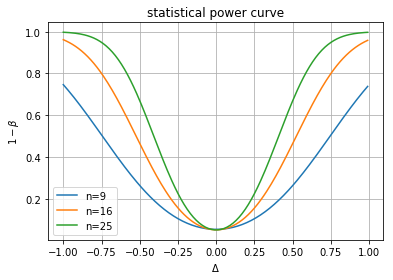

In [84]:
n_list = [9, 16, 25]
delta_list = np.arange(-1, 1, 0.01).tolist()

#fig = plt.figure()
for index, n in enumerate(n_list):
    #ax = fig.add_subplot(len(n_list), 1, index+1)
    #ax.plot(delta_list, [statistical_power_mean_mu_ne_mu0(delta=delta, n=n) for delta in delta_list], label=n)
    plt.plot(delta_list, [statistical_power_mean_Vunknown_mu_ne_mu0(delta=delta, n=n) for delta in delta_list], label="n="+str(n))
    

plt.title("statistical power curve")
plt.xlabel(r"$\Delta$")
plt.ylabel(r"$1-\beta$")
plt.grid()
plt.legend()

In [89]:
#H0:mu=mu0, H1:mu!=mu0の場合のサンプルサイズ

def size_mean_Vunknown_mu_larger_mu0(delta, mu=None, mu0=None, sigma=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 5.17
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma):
        delta = (mu-mu0)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu, mu0, sigma0")
       
    z_alpha =norm.isf(q=alpha, loc=0, scale=1)
    z_one_minus_beta = norm.isf(q=one_minus_beta, loc=0, scale=1)
    #print(z_alpha, z_one_minus_beta)
    n = ((z_alpha-z_one_minus_beta)/delta)**2+(z_alpha**2)/2
    
    return n

print(size_mean_Vunknown_mu_larger_mu0(0.5, alpha=0.05, one_minus_beta=0.95))

def statistical_power_mean_Vunknown_mu_larger_mu0(delta, n, mu=None, mu0=None, sigma=None, alpha=0.05):
    #Eq. 5.13
    phi = n-1
    
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma):
        delta = (mu-mu0)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu, mu0, sigma0")
        
    noncentral_lambda = np.sqrt(n)*delta
    t_stat = t.isf(q=alpha/2*2, df=phi)
    
    def approx_noncentral_t_cdf(w, phi, noncentral_lambda):
        #Eq. 5.11
        return norm.cdf((w*(1-1/(4*phi))-noncentral_lambda)/np.sqrt(1+(w**2)/(2*phi)))
    
    one_minus_beta = (1-approx_noncentral_t_cdf(t_stat, phi, noncentral_lambda))
    
    return one_minus_beta

print(statistical_power_mean_Vunknown_mu_larger_mu0(delta=0.6, n=9, alpha=0.05))
print(statistical_power_mean_Vunknown_mu_larger_mu0(delta=0.5, n=45, alpha=0.05))
print(statistical_power_mean_Vunknown_mu_larger_mu0(delta=0.5, n=44, alpha=0.05))


1.64485362695 -1.64485362695
44.6414669926
0.49948009108
0.951245142707
0.947270252822


In [90]:
#H0:mu=mu0, H1:mu!=mu0の場合のサンプルサイズ

def size_mean_Vunknown_mu_smaller_mu0(delta, mu=None, mu0=None, sigma=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 5.18
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma):
        delta = (mu-mu0)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu, mu0, sigma0")
    
    return size_mean_Vunknown_mu_larger_mu0(-delta, alpha=alpha, one_minus_beta=one_minus_beta)



def statistical_power_mean_Vunknown_mu_smaller_mu0(delta, n, mu=None, mu0=None, sigma=None, alpha=0.05):
    #Eq. 5.13
    phi = n-1
    
    if delta:
        pass
    
    elif (delta==None) & (mu&mu0&sigma):
        delta = (mu-mu0)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu, mu0, sigma0")
        
    noncentral_lambda = np.sqrt(n)*delta
    t_stat = t.isf(q=alpha/2*2, df=phi)
    
    def approx_noncentral_t_cdf(w, phi, noncentral_lambda):
        #Eq. 5.11
        return norm.cdf((w*(1-1/(4*phi))-noncentral_lambda)/np.sqrt(1+(w**2)/(2*phi)))
    
    one_minus_beta = approx_noncentral_t_cdf(-t_stat, phi, noncentral_lambda)
    
    return one_minus_beta

print(size_mean_Vunknown_mu_smaller_mu0(-0.5, alpha=0.05, one_minus_beta=0.80))
print(statistical_power_mean_Vunknown_mu_smaller_mu0(delta=-0.6, n=9, alpha=0.05))
print(statistical_power_mean_Vunknown_mu_smaller_mu0(delta=-0.5, n=27, alpha=0.05))
print(statistical_power_mean_Vunknown_mu_smaller_mu0(delta=-0.5, n=26, alpha=0.05))


1.64485362695 -0.841621233573
26.0830006551
0.49948009108
0.811774620391
0.797985856406


In [91]:
from scipy.stats import nct

In [96]:
def approx_noncentral_t_cdf(w, #statistic value
                            phi, #degree of freedom
                            noncentral_lambda #noncentral parameter 
                           ):
    #Eq. 5.11
    return norm.cdf((w*(1-1/(4*phi))-noncentral_lambda)/np.sqrt(1+(w**2)/(2*phi)))

"""
The probability density above is defined in the “standardized” form. 
To shift and/or scale the distribution use the loc and scale parameters. 
Specifically, nct.pdf(x, df, nc, loc, scale) is identically equivalent to nct.pdf(y, df, nc) / scale with y = (x - loc) / scale.
"""
nct.cdf(x, df, nc, loc=0, scale=1)

NameError: name 'x' is not defined

In [109]:
print("Noncentral Student t distribution")
#p. 73 ex5.5
print("exact value\t\t", nct.cdf(x=-1.860, df=9-1, nc=-1.8))
#nct.cdf(x, df, nc)=approx_noncentral_t_cdf(w=x, phi=df, noncentral_lambda=nc)
print("approximate value\t", approx_noncentral_t_cdf(w=-1.860, phi=9-1, noncentral_lambda=-1.8))

Noncentral Student t distribution
exact value		 0.500235318212
approximate value	 0.499321727568


In [105]:
approx_noncentral_t_cdf(w=-1.860, phi=9-1, noncentral_lambda=-1.8)

0.49932172756838739

In [114]:
from scipy.stats import f

In [118]:
"""
2つの母分散の比の検定
"""

def size_var_ratio_sigma1_ne_sigma2(delta, sigma1=None, sigma2=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 6.24, 6.25
    if delta:
        pass
    
    elif (delta==None) & (sigma1!=sigma2):
        delta = sigma1/sigma2
        
    else:
        raise ValueError("Must set delta as a threshold or set sigma1, sigma2")
    
    z_alpha_over_two =norm.isf(q=alpha/2, loc=0, scale=1)
    z_one_minus_beta = norm.isf(q=one_minus_beta, loc=0, scale=1)
    
    n = 1+((z_alpha_over_two-z_one_minus_beta)/np.log(delta))**2
    return n


def statistical_power_var_ratio_sigma1_ne_sigma2(delta, n, sigma1=None, sigma2=None, alpha=0.05):
    #Eq. 6.14
    if delta:
        pass
    
    elif (delta==None) & (sigma1!=sigma2):
        delta = sigma1/sigma2
        
    else:
        raise ValueError("Must set delta as a threshold or set sigma1, sigma2")
        
    n1=n
    n2=n
    one_minus_beta = f.cdf(f.isf(q=1-alpha/2, dfn=n1-1, dfd=n2-1, loc=0, scale=1)/(delta**2), dfn=n1-1, dfd=n2-1
                               ) + (f.sf(f.isf(q=alpha/2, dfn=n1-1, dfd=n2-1,  loc=0, scale=1)/(delta**2), dfn=n1-1, dfd=n2-1))
    
    return one_minus_beta


print(size_var_ratio_sigma1_ne_sigma2(delta=5/2, sigma1=None, sigma2=None, alpha=0.05, one_minus_beta=0.9))
print(statistical_power_var_ratio_sigma1_ne_sigma2(delta=5/2, n=14))
print(statistical_power_var_ratio_sigma1_ne_sigma2(delta=5/2, n=15))
print(size_var_ratio_sigma1_ne_sigma2(delta=1/2, sigma1=None, sigma2=None, alpha=0.05, one_minus_beta=0.9))
print(statistical_power_var_ratio_sigma1_ne_sigma2(delta=1/2, n=23))
print(statistical_power_var_ratio_sigma1_ne_sigma2(delta=1/2, n=24))

13.5149647618
0.888691493473
0.911038181326
22.8698244304
0.888497779214
0.901948707189


In [124]:
"""
2つの母分散の日の検定
"""

def size_var_ratio_sigma1_larger_sigma2(delta, sigma1=None, sigma2=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 6.26
    if delta:
        pass
    
    elif (delta==None) & (sigma1!=sigma2):
        delta = sigma1/sigma2
        
    else:
        raise ValueError("Must set delta as a threshold or set sigma1, sigma2")
    
    z_alpha =norm.isf(q=alpha, loc=0, scale=1)
    z_one_minus_beta = norm.isf(q=one_minus_beta, loc=0, scale=1)
    
    n = 1+((z_alpha-z_one_minus_beta)/np.log(delta))**2
    return n


def statistical_power_var_ratio_sigma1_larger_sigma2(delta, n, sigma1=None, sigma2=None, alpha=0.05):
    #Eq. 6.26
    if delta:
        pass
    
    elif (delta==None) & (sigma1!=sigma2):
        delta = sigma1/sigma2
        
    else:
        raise ValueError("Must set delta as a threshold or set sigma1, sigma2")
        
    n1=n
    n2=n
    one_minus_beta = f.sf(f.isf(q=alpha, dfn=n1-1, dfd=n2-1, loc=0, scale=1)/(delta**2), dfn=n1-1, dfd=n2-1)
    
    return one_minus_beta


print(size_var_ratio_sigma1_larger_sigma2(delta=2.0, sigma1=None, sigma2=None, alpha=0.05, one_minus_beta=0.8))
print(statistical_power_var_ratio_sigma1_larger_sigma2(delta=2.0, n=14))
print(statistical_power_var_ratio_sigma1_larger_sigma2(delta=2.0, n=15))


13.868182846
0.780698491756
0.808323144763


In [127]:
"""
2つの母分散の日の検定
"""

def size_var_ratio_sigma1_smaller_sigma2(delta, sigma1=None, sigma2=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 6.26
    if delta:
        pass
    
    elif (delta==None) & (sigma1!=sigma2):
        delta = sigma1/sigma2
        
    else:
        raise ValueError("Must set delta as a threshold or set sigma1, sigma2")
    
    return size_var_ratio_sigma1_larger_sigma2(delta=delta, sigma1=None, sigma2=None, alpha=alpha, one_minus_beta=one_minus_beta)


def statistical_power_var_ratio_sigma1_smaller_sigma2(delta, n, sigma1=None, sigma2=None, alpha=0.05):
    #Eq. 6.21
    if delta:
        pass
    
    elif (delta==None) & (sigma1!=sigma2):
        delta = sigma1/sigma2
        
    else:
        raise ValueError("Must set delta as a threshold or set sigma1, sigma2")
        
    n1=n
    n2=n
    one_minus_beta = f.cdf(f.isf(q=1-alpha, dfn=n1-1, dfd=n2-1, loc=0, scale=1)/(delta**2), dfn=n1-1, dfd=n2-1)
    
    return one_minus_beta


print(size_var_ratio_sigma1_smaller_sigma2(delta=1/3, sigma1=None, sigma2=None, alpha=0.05, one_minus_beta=0.95))
print(statistical_power_var_ratio_sigma1_smaller_sigma2(delta=1/3, n=10))
print(statistical_power_var_ratio_sigma1_smaller_sigma2(delta=1/3, n=11))


9.96655464958
0.931489428538
0.952126037485


In [132]:
"""
２つの母平均の差の検定
"""
#H0:mu=mu0, H1:mu!=mu0の場合のサンプルサイズ

def size_mean_diff_mu1_ne_mu2(delta, mu1=None, mu2=None, sigma=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 7.17
    if delta:
        pass
    
    elif (delta==None) & (mu1&mu2&sigma):
        delta = (mu1-mu2)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu1, mu2, sigma0")
    
    z_alpha_over_two =norm.isf(q=alpha/2, loc=0, scale=1)
    z_one_minus_beta = norm.isf(q=one_minus_beta, loc=0, scale=1)
    n = 2*((z_alpha_over_two-z_one_minus_beta)/delta)**2+(z_alpha_over_two**2)/4
    
    return n




def statistical_power_mean_diff_mu1_ne_mu2(delta, n, n1=None, n2=None, mu1=None, mu2=None, sigma=None, alpha=0.05):
    #Eq. 7.11
    if n1 and n2:
        pass
    elif n:
        n1=n
        n2=n
    else:
        raise ValueError("Must set n or n1 and n2")
    
    phi = (n1-1)+(n2-1)
    
    if delta:
        pass
    
    elif (delta==None) & (mu1&mu2&sigma):
        delta = (mu1-mu2)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu1, mu2, sigma0")
        
    noncentral_lambda = np.sqrt((n1*n2)/(n1+n2))*delta
    t_stat = t.isf(q=alpha/2, df=phi)
    
    def approx_noncentral_t_cdf(w, phi, noncentral_lambda):
        #Eq. 5.11
        return norm.cdf((w*(1-1/(4*phi))-noncentral_lambda)/np.sqrt(1+(w**2)/(2*phi)))

    one_minus_beta = approx_noncentral_t_cdf(-t_stat, phi, noncentral_lambda)+(
        1-approx_noncentral_t_cdf(t_stat, phi, noncentral_lambda))
    
    return one_minus_beta


print(size_mean_diff_mu1_ne_mu2(1.0, alpha=0.05, one_minus_beta=0.9))
print(statistical_power_mean_diff_mu1_ne_mu2(delta=1.0, n=22, alpha=0.05))
print(statistical_power_mean_diff_mu1_ne_mu2(delta=1.0, n=21, alpha=0.05))


21.9752108281
0.899709156372
0.885246957684


In [133]:
"""
２つの母平均の差の検定
"""
def size_mean_diff_mu1_larger_mu2(delta, mu1=None, mu2=None, sigma=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 7.17
    if delta:
        pass
    
    elif (delta==None) & (mu1&mu2&sigma):
        delta = (mu1-mu2)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu1, mu2, sigma0")
    
    z_alpha =norm.isf(q=alpha, loc=0, scale=1)
    z_one_minus_beta = norm.isf(q=one_minus_beta, loc=0, scale=1)
    n = 2*((z_alpha-z_one_minus_beta)/delta)**2+(z_alpha**2)/4
    
    return n




def statistical_power_mean_diff_mu1_larger_mu2(delta, n, n1=None, n2=None, mu1=None, mu2=None, sigma=None, alpha=0.05):
    #Eq. 7.14
    if n1 and n2:
        pass
    elif n:
        n1=n
        n2=n
    else:
        raise ValueError("Must set n or n1 and n2")
    
    phi = (n1-1)+(n2-1)
    
    if delta:
        pass
    
    elif (delta==None) & (mu1&mu2&sigma):
        delta = (mu1-mu2)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu1, mu2, sigma0")
        
    noncentral_lambda = np.sqrt((n1*n2)/(n1+n2))*delta
    t_stat = t.isf(q=alpha, df=phi)
    
    def approx_noncentral_t_cdf(w, phi, noncentral_lambda):
        #Eq. 5.11
        return norm.cdf((w*(1-1/(4*phi))-noncentral_lambda)/np.sqrt(1+(w**2)/(2*phi)))

    one_minus_beta = (1-approx_noncentral_t_cdf(t_stat, phi, noncentral_lambda))
    
    return one_minus_beta


print(size_mean_diff_mu1_larger_mu2(1.5, alpha=0.05, one_minus_beta=0.95))
print(statistical_power_mean_diff_mu1_larger_mu2(delta=1.5, n=11, alpha=0.05))
print(statistical_power_mean_diff_mu1_larger_mu2(delta=1.5, n=10, alpha=0.05))

10.2960959225
0.960003131291
0.942887069568


In [135]:
"""
２つの母平均の差の検定
"""
def size_mean_diff_mu1_smaller_mu2(delta, mu1=None, mu2=None, sigma=None, alpha=0.05, one_minus_beta=0.9):
    #Eq. 7.19
    if delta:
        pass
    
    elif (delta==None) & (mu1&mu2&sigma):
        delta = (mu1-mu2)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu1, mu2, sigma0")
       
    return size_mean_diff_mu1_larger_mu2(delta=delta, mu1=None, mu2=None, sigma=None, alpha=alpha, one_minus_beta=one_minus_beta)




def statistical_power_mean_diff_mu1_smaller_mu2(delta, n, n1=None, n2=None, mu1=None, mu2=None, sigma=None, alpha=0.05):
    #Eq. 7.16
    if n1 and n2:
        pass
    elif n:
        n1=n
        n2=n
    else:
        raise ValueError("Must set n or n1 and n2")
    
    phi = (n1-1)+(n2-1)
    
    if delta:
        pass
    
    elif (delta==None) & (mu1&mu2&sigma):
        delta = (mu1-mu2)/sigma
        
    else:
        raise ValueError("Must set delta as a threshold or set mu1, mu2, sigma0")
        
    noncentral_lambda = np.sqrt((n1*n2)/(n1+n2))*delta
    t_stat = t.isf(q=alpha, df=phi)
    
    def approx_noncentral_t_cdf(w, phi, noncentral_lambda):
        #Eq. 5.11
        return norm.cdf((w*(1-1/(4*phi))-noncentral_lambda)/np.sqrt(1+(w**2)/(2*phi)))

    one_minus_beta = approx_noncentral_t_cdf(-t_stat, phi, noncentral_lambda)
    
    return one_minus_beta


print(size_mean_diff_mu1_smaller_mu2(-1.2, alpha=0.05, one_minus_beta=0.80))
print(statistical_power_mean_diff_mu1_smaller_mu2(delta=-1.2, n=10, alpha=0.05))
print(statistical_power_mean_diff_mu1_smaller_mu2(delta=-1.2, n=9, alpha=0.05))

9.263270908
0.825114833007
0.785294914835


In [139]:
"""
母不良率の
"""

def size_ratio():
    #Eq. 11.8, Ex 11.2
    pass

def statistical_power_ratio(n, P, P0, alpha=0.05):
    #Eq. 11.5-7
    if (n*P<5) | (n*(1-P)<5) | (n*P0<5) | (n*(1-P0)<5):
        raise ValueError("Cannot use norm dist approx")
        
    A = np.sqrt((P0*(1-P0))/(P*(1-P)))
    B = (P-P0)/np.sqrt((P*(1-P))/n)
    z_alpha_over_two =norm.isf(q=alpha/2, loc=0, scale=1)
    
    one_minus_beta = norm.cdf(-z_alpha_over_two*A-B, loc=0, scale=1) + norm.sf(z_alpha_over_two*A-B, loc=0, scale=1)
    return one_minus_beta

print(statistical_power_ratio(n=200, P=0.05, P0=0.10))

0.707655682635


In [142]:
z_one_minus_beta = norm.isf(q=0.90, loc=0, scale=1)

# 区間推定に基づくサンプルサイズ設計

In [143]:
"""
一つの母平均の区間推定 母分散既知
"""

def size_mean_interval(alpha, delta, sigma0_2):
    #Eq. 12.6
    z_alpha_over_two = norm.isf(q=alpha/2, loc=0, scale=1)
    n = (4*(z_alpha_over_two**2)*sigma0_2)/(delta**2)
    return n

print(size_mean_interval(alpha=0.05, delta=3.0, sigma0_2=2.0**2))

6.82926012568


In [144]:
"""
一つの母分散の区間推定 
"""

def size_var_interval(alpha, delta):
    # Eq. 12.12
    z_alpha_over_two = norm.isf(q=alpha/2, loc=0, scale=1)
    n = (1/2)*(((1+np.sqrt(delta))*z_alpha_over_two/(np.sqrt(delta)-1))**2)+(3/2)
    return n

print(size_var_interval(alpha=0.05, delta=3.0))

28.2523095777


In [145]:
from scipy.special import gamma

In [ ]:
"""
一つの母平均の区間推定 母分散未知
"""

def size_mean_interval_Vunknown(alpha, delta):
    pass

# フィッティング

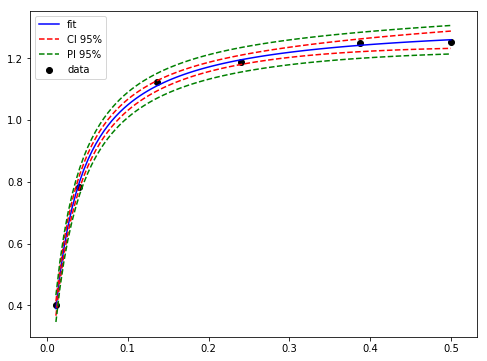

In [154]:
from scipy.optimize import curve_fit
from scipy import stats

"""
def func(x, a, b):
    return a * (1-np.exp(b+x))
xd = np.linspace(0, 10, 100)
yd = 1 * np.random.randn(xd.size) + func(x, 1, -4)
"""


xd = np.array([0.5, 0.387, 0.24, 0.136, 0.04, 0.011])
yd = np.array([1.255, 1.25, 1.189, 1.124, 0.783, 0.402])

##
# for fitting
##

# this is the function we want to fit to our data
def func(x, a, b):
    """nonlinear function in a and b to fit to data"""
    return a * x / (b + x)

def transient(x, A, B, tau):
    return 1-A*np.exp(-x/tau)+B

def sigmoid(x, a, b):
    return 1/(1+np.exp(-a*(x-b)))

def transient_inverse(x, A, B, tau):
    return tau * np.log(A/(1+B+x))

def logit(x, a, b):
    return (1/a) * np.log(x/(1-x)) + b


def statband(x, xd, yd, f_vars, conf=0.95, kind="confidence"):
    """
    Code adapted from Rodrigo Nemmen's post:
    http://astropython.blogspot.com.ar/2011/12/calculating-prediction-band-
    of-linear.html

    Calculates the prediction band of the regression model at the
    desired confidence level.

    Clarification of the difference between confidence and prediction bands:

    "The prediction bands are further from the best-fit line than the
    confidence bands, a lot further if you have many data points. The 95%
    prediction band is the area in which you expect 95% of all data points
    to fall. In contrast, the 95% confidence band is the area that has a
    95% chance of containing the true regression line."
    (from http://www.graphpad.com/guides/prism/6/curve-fitting/index.htm?
    reg_graphing_tips_linear_regressio.htm)

    Arguments:
    - x: array with x values to calculate the confidence band.
    - xd, yd: data arrays.
    - a, b, c: linear fit parameters.
    - conf: desired confidence level, by default 0.95 (2 sigma)

    References:
    1. http://www.JerryDallal.com/LHSP/slr.htm, Introduction to Simple Linear
    Regression, Gerard E. Dallal, Ph.D.
    """

    alpha = 1. - conf    # Significance
    N = xd.size          # data sample size
    var_n = len(f_vars)  # Number of variables used by the fitted function.

    # Quantile of Student's t distribution for p=(1 - alpha/2)
    q = stats.t.ppf(1. - alpha / 2., N - var_n)

    # Std. deviation of an individual measurement (Bevington, eq. 6.15)
    se = np.sqrt(1. / (N - var_n) * np.sum((yd - func(xd, *f_vars)) ** 2))

    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)

    # Predicted values (best-fit model)
    yp = func(x, *f_vars)
    # Confidence/Prediction band
    if kind=="confidence":
        dy = q * se * np.sqrt((1. / N)+(sx / sxd))
    elif kind=="prediction":
        dy = q * se * np.sqrt(1. + (1. / N) + (sx / sxd))
    else:
        raise ValueError("kind must be confidence/prediction.")

    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy

    return lpb, upb


# Find best fit of data with 3-parameters exponential function.
popt, pcov = curve_fit(func, xd, yd)

# Generate equi-spaced x values.
x = np.linspace(xd.min(), xd.max(), 100)

# Call function to generate lower an upper prediction bands.
lpb, upb = statband(x, xd, yd, popt, conf=0.95, kind="prediction")
lcb, ucb = statband(x, xd, yd, popt, conf=0.95, kind="confidence")

plt.figure(figsize=(8,6))
plt.scatter(xd, yd, marker="o", color="k", label="data")
plt.plot(x, func(x, *popt), color="b", label="fit")
plt.plot(x, lcb, "--", color="r", label="CI 95%")
plt.plot(x, ucb, "--", color="r")
plt.plot(x, lpb, "--", color="g", label="PI 95%")
plt.plot(x, upb, "--", color="g")
plt.legend()

confidence level: 0.95
    Estimate  Std. Error      lwCI      upCI
p1  1.327531    0.009723  1.300537  1.354526
p0  0.026462    0.001028  0.023608  0.029315


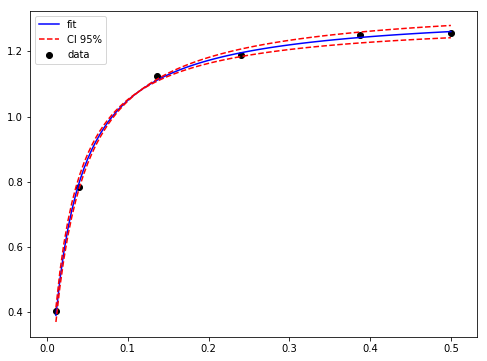

In [156]:
#http://kitchingroup.cheme.cmu.edu/blog/2013/02/12/Nonlinear-curve-fitting-with-parameter-confidence-intervals/
#https://omedstu.jimdo.com/2018/07/16/python%E3%81%A7gaussian-fitting/
#https://jp.mathworks.com/help/stats/nlinfit.html
#https://org-technology.com/posts/scipy-least-square-fitting.html

# Nonlinear curve fit with confidence interval
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

x = np.array([0.5, 0.387, 0.24, 0.136, 0.04, 0.011])
y = np.array([1.255, 1.25, 1.189, 1.124, 0.783, 0.402])

# this is the function we want to fit to our data
def func(x, a, b):
    'nonlinear function in a and b to fit to data'
    return a * x / (b + x)

def paramband(x, y, popt, pcov, conf=0.95, hide=False):
    alpha = 0.05 # 95% confidence interval = 100*(1-alpha)
    n = len(y)    # number of data points
    p = len(popt) # number of parameters
    dof = max(0, n - p) # number of degrees of freedom

    # student-t value for the dof and confidence level
    tval = t.ppf(1.0-alpha/2., dof) 

    #estimate standard Error
    SE = np.sqrt(np.diag(pcov))
    #estimate confidence interval of parameters
    lwCI = popt-tval*SE
    upCI = popt+tval*SE
    
    # estimate standard Error
    #StdE = np.sqrt(np.diag(pcov))
    #lwCI = popt + norm.ppf(q=alpha)*StdE
    #upCI = popt + norm.ppf(q=1-alpha)*StdE

    index = set()
    for i in range(p):
        index.add("p"+str(i))
    
    # print result
    mat = np.vstack((popt,SE, lwCI, upCI)).T 
    df=pd.DataFrame(mat,index=index,
                    columns=("Estimate", "Std. Error", "lwCI","upCI"))
    
    if not hide:
        print("confidence level:", conf)
        print(df)
    
    return df

xd = np.array([0.5, 0.387, 0.24, 0.136, 0.04, 0.011])
yd = np.array([1.255, 1.25, 1.189, 1.124, 0.783, 0.402])

initial_guess = [1.2, 0.03]
#Levenberg-Marquardt法で最小二乗問題の解を求める
popt, pcov = curve_fit(func, x, y, p0=initial_guess)

ci = paramband(xd, yd, popt, pcov)

plt.figure(figsize=(8,6))
plt.scatter(xd, yd, marker="o", color="k", label="data")
x = np.linspace(xd.min(), xd.max(), 100)
plt.plot(x, func(x, *popt), color="b", label="fit")
plt.plot(x, func(x, *ci["lwCI"]), "--", color="r", label="CI 95%")
plt.plot(x, func(x, *ci["upCI"]), "--", color="r")
plt.legend()

In [155]:
popt

array([ 1.32753143,  0.02646156])